In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import RobertaTokenizer, TFRobertaModel


In [2]:
# Set up the TPU or GPU strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU:', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('Running on GPU:', strategy.num_replicas_in_sync)

Running on GPU: 1


In [3]:
# Constants
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

In [ ]:
# Read the dataset
df = pd.read_csv('C:/Users/.......  /.csv')

In [5]:
columns = df.columns.tolist()
print(columns)

['Text', 'Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6', 'Task7', 'Task8', 'Task9', 'Task10', 'Task11', 'Task12', 'Task13', 'Task14', 'Task15']


In [6]:
df.head()

,Text,Task1,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9,Task10,Task11,Task12,Task13,Task14,Task15
0,i didn't spend all my money buying squishmallo...,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1
1,It was a busy day at work and as I was quite b...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,Ive been reading a book that helped answer a l...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,I worked out. tough. worked out. working out i...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
4,"The situation was not that easy to handle, but...",0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [7]:
# Split the dataset into X_data (text) and task labels (Task1 to Task14)
X_data = df['Text'].values
task_labels = df.iloc[:, 1:14].values.astype('int32')
presence_labels = df['Task15'].values.astype('int32')

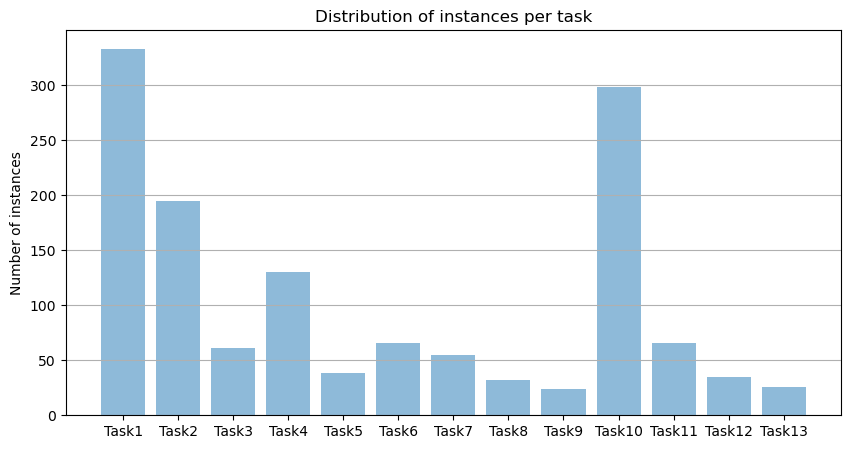

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'task_labels' is a NumPy ndarray containing the task labels
task_labels_sum = np.sum(task_labels[:, :13], axis=0)
task_names = ['Task' + str(i) for i in range(1, 14)]

plt.figure(figsize=(10, 5))
plt.bar(task_names, task_labels_sum, align='center', alpha=0.5)
plt.ylabel('Number of instances')
plt.title('Distribution of instances per task')
plt.gca().yaxis.grid(True)
plt.show()


In [9]:
# Split the dataset into train and test sets
X_train, X_test, y_train_task, y_test_task, y_train_presence, y_test_presence = train_test_split(
    X_data, task_labels, presence_labels, test_size=0.3, random_state=777)


In [10]:
# Initialize the Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [11]:
# Encode the text data using the tokenizer
def roberta_encode(texts, tokenizer):
    input_ids = np.ones((len(texts), MAX_LEN), dtype='int32')
    attention_mask = np.zeros((len(texts), MAX_LEN), dtype='int32')

    for i, text in enumerate(texts):
        tokens = tokenizer.tokenize(text)
        tokens = tokens[:MAX_LEN-2]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        input_ids[i, :len(tokens)] = tokenizer.convert_tokens_to_ids(tokens)
        attention_mask[i, :len(tokens)] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask
    }

In [12]:
# Encode the train and test data
X_train_encoded = roberta_encode(X_train, tokenizer)
X_test_encoded = roberta_encode(X_test, tokenizer)


In [13]:
# Define the Multitask Cascaded Roberta model
def build_model():
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')

        roberta = TFRobertaModel.from_pretrained(MODEL_NAME)
        roberta.resize_token_embeddings(len(tokenizer))

        sequence_output = roberta(input_word_ids, attention_mask=input_mask)[0]
        cls_token = sequence_output[:, 0, :]

        presence_output = tf.keras.layers.Dense(1, activation='sigmoid', name='presence_output')(cls_token)
        task_output = tf.keras.layers.Dense(13, activation='sigmoid', name='task_output')(cls_token)

        task_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        presence_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

        task_metrics = [tf.keras.metrics.BinaryAccuracy(name='task{}_accuracy'.format(i+1)) for i in range(13)]
        presence_metrics = tf.keras.metrics.BinaryAccuracy(name='presence_accuracy')

        model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=[task_output, presence_output])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss={'task_output': task_loss, 'presence_output': presence_loss},
                      metrics={'task_output': task_metrics, 'presence_output': presence_metrics})

    return model


In [14]:
# Build and compile the model
model = build_model()
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [15]:
# Train the model
history = model.fit(
    x=X_train_encoded,
    y={'task_output': y_train_task, 'presence_output': y_train_presence},
    validation_data=(X_test_encoded, {'task_output': y_test_task, 'presence_output': y_test_presence}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)



Epoch 1/3
131/131 [==============================] - 1578s 12s/step - loss: 0.5661 - task_output_loss: 0.3097 - presence_output_loss: 0.2565 - task_output_task1_accuracy: 0.8878 - task_output_task2_accuracy: 0.8878 - task_output_task3_accuracy: 0.8878 - task_output_task4_accuracy: 0.8878 - task_output_task5_accuracy: 0.8878 - task_output_task6_accuracy: 0.8878 - task_output_task7_accuracy: 0.8878 - task_output_task8_accuracy: 0.8878 - task_output_task9_accuracy: 0.8878 - task_output_task10_accuracy: 0.8878 - task_output_task11_accuracy: 0.8878 - task_output_task12_accuracy: 0.8878 - task_output_task13_accuracy: 0.8878 - presence_output_presence_accuracy: 0.9294 - val_loss: 0.4283 - val_task_output_loss: 0.2325 - val_presence_output_loss: 0.1958 - val_task_output_task1_accuracy: 0.9274 - val_task_output_task2_accuracy: 0.9274 - val_task_output_task3_accuracy: 0.9274 - val_task_output_task4_accuracy: 0.9274 - val_task_output_task5_accuracy: 0.9274 - val_task_output_task6_accuracy: 0.9274

In [16]:
# Evaluate the model
test_scores = model.evaluate(
    x=X_test_encoded,
    y={'task_output': y_test_task, 'presence_output': y_test_presence},
    batch_size=BATCH_SIZE,
    verbose=1
)



57/57 [==============================] - 164s 3s/step - loss: 0.4072 - task_output_loss: 0.2118 - presence_output_loss: 0.1953 - task_output_task1_accuracy: 0.9282 - task_output_task2_accuracy: 0.9282 - task_output_task3_accuracy: 0.9282 - task_output_task4_accuracy: 0.9282 - task_output_task5_accuracy: 0.9282 - task_output_task6_accuracy: 0.9282 - task_output_task7_accuracy: 0.9282 - task_output_task8_accuracy: 0.9282 - task_output_task9_accuracy: 0.9282 - task_output_task10_accuracy: 0.9282 - task_output_task11_accuracy: 0.9282 - task_output_task12_accuracy: 0.9282 - task_output_task13_accuracy: 0.9282 - presence_output_presence_accuracy: 0.9356


In [17]:
y_test_presence

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [19]:
#presence_predictions

In [ ]:
# Convert presence predictions to binary values using a threshold of 0.5
#binary_presence_predictions = np.round(presence_predictions).flatten().astype(int)

# Convert y_test_presence to integer type if it's not already
#y_test_presence = y_test_presence.astype(int)

# Calculate presence accuracy
#presence_accuracy = accuracy_score(y_test_presence, binary_presence_predictions)


In [21]:
from sklearn.metrics import accuracy_score

# Make predictions
predictions = model.predict(X_test_encoded)

# Extract task and presence predictions
task_predictions = predictions[0]
presence_predictions = predictions[1]

# Convert task predictions to binary values
binary_task_predictions = np.round(task_predictions)

# Calculate task accuracies
task_accuracies = []
for i in range(13):
    task_accuracy = accuracy_score(y_test_task[:, i], binary_task_predictions[:, i])
    task_accuracies.append(task_accuracy)

# Convert presence predictions to binary values using a threshold of 0.5
binary_presence_predictions = np.round(presence_predictions).flatten().astype(int)

# Convert y_test_presence to integer type if it's not already
y_test_presence = y_test_presence.astype(int)

# Calculate presence accuracy
presence_accuracy = accuracy_score(y_test_presence, binary_presence_predictions)

# Print the evaluation results
print("Test Loss:", test_scores[0])
print("Task Output Accuracies:")
for i in range(13):
    print("Task{} Accuracy: {}".format(i+1, task_accuracies[i]))
print("Presence Output Accuracy:", presence_accuracy)


15/15 [==============================] - 152s 10s/step
Test Loss: 0.4071577489376068
Task Output Accuracies:
Task1 Accuracy: 0.7644444444444445
Task2 Accuracy: 0.8511111111111112
Task3 Accuracy: 0.96
Task4 Accuracy: 0.9311111111111111
Task5 Accuracy: 0.9711111111111111
Task6 Accuracy: 0.9511111111111111
Task7 Accuracy: 0.9622222222222222
Task8 Accuracy: 0.9888888888888889
Task9 Accuracy: 0.98
Task10 Accuracy: 0.7955555555555556
Task11 Accuracy: 0.9533333333333334
Task12 Accuracy: 0.9688888888888889
Task13 Accuracy: 0.9888888888888889
Presence Output Accuracy: 0.9355555555555556


In [26]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
predictions = model.predict(X_test_encoded)

# Extract task and presence predictions
task_predictions = predictions[0]
presence_predictions = predictions[1]

# Convert task predictions to binary values
binary_task_predictions = np.round(task_predictions)

# Calculate task accuracies
task_accuracies = []
for i in range(13):
    task_accuracy = accuracy_score(y_test_task[:, i], binary_task_predictions[:, i])
    task_accuracies.append(task_accuracy)

# Convert presence predictions to binary values using a threshold of 0.5
binary_presence_predictions = np.round(presence_predictions).flatten().astype(int)

# Convert y_test_presence to integer type if it's not already
y_test_presence = y_test_presence.astype(int)

# Calculate precision, recall, and F1 score
target_names = ['Task1', 'Task2', 'Task3', 'Task4', 'Task5', 'Task6', 'Task7', 'Task8', 'Task9', 'Task10', 'Task11', 'Task12','Task13']
task_report = classification_report(y_test_task, binary_task_predictions, target_names=target_names)

# Print the evaluation results
print("Task Output Accuracies:")
for i in range(13):
    print("Task{} Accuracy: {}".format(i+1, task_accuracies[i]))
print("Presence Output Accuracy:", presence_accuracy)
print("Task Output Metrics:")
print(task_report)


15/15 [==============================] - 141s 9s/step
Task Output Accuracies:
Task1 Accuracy: 0.7644444444444445
Task2 Accuracy: 0.8511111111111112
Task3 Accuracy: 0.96
Task4 Accuracy: 0.9311111111111111
Task5 Accuracy: 0.9711111111111111
Task6 Accuracy: 0.9511111111111111
Task7 Accuracy: 0.9622222222222222
Task8 Accuracy: 0.9888888888888889
Task9 Accuracy: 0.98
Task10 Accuracy: 0.7955555555555556
Task11 Accuracy: 0.9533333333333334
Task12 Accuracy: 0.9688888888888889
Task13 Accuracy: 0.9888888888888889
Presence Output Accuracy: 0.9355555555555556
Task Output Metrics:
              precision    recall  f1-score   support

       Task1       0.00      0.00      0.00       106
       Task2       0.00      0.00      0.00        67
       Task3       0.00      0.00      0.00        18
       Task4       0.86      0.17      0.28        36
       Task5       0.00      0.00      0.00        13
       Task6       0.00      0.00      0.00        22
       Task7       0.00      0.00      0.00   

C:\Users\madha\anaconda3\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\madha\anaconda3\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\madha\anaconda3\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Calculating metrics - precision, recall, and F1 score for each task
precision = []
recall = []
f1_measure = []

for i in range(1, 16):  # Iterate from 1 to 14
    task_precision = precision_score(y_test_task, np.round(task_predictions), average=None)
    task_recall = recall_score(y_test_task, np.round(task_predictions), average=None)
    task_f1 = f1_score(y_test_task, np.round(task_predictions), average=None)
    
    precision.append(task_precision)
    recall.append(task_recall)
    f1_measure.append(task_f1)

# Print precision, recall, and F1 score for each task
print('Precision per Task:')
for i, p in enumerate(precision):
    print(f'Task {i+1}: {p}')
    
print('Recall per Task:')
for i, r in enumerate(recall):
    print(f'Task {i+1}: {r}')
    
print('F1 Score per Task:')
for i, f in enumerate(f1_measure):
    print(f'Task {i+1}: {f}')


C:\Users\madha\anaconda3\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\madha\anaconda3\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\madha\anaconda3\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\madha\anaconda3\ANACONDA\lib\site-packages\sklearn\metrics

Precision per Task:
Task 1: [0.         0.         0.         0.85714286 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Task 2: [0.         0.         0.         0.85714286 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Task 3: [0.         0.         0.         0.85714286 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Task 4: [0.         0.         0.         0.85714286 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Task 5: [0.         0.         0.         0.85714286 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Task 6: [0.         0.         0.         0.85714286 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Task 7: [0.         0.         0.         0.85714286 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Task 8:

In [29]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score
task_precisions, task_recalls, task_f1_scores, _ = precision_recall_fscore_support(
    y_test_task, binary_task_predictions, average=None)

# Print the evaluation results
print("Task Output Metrics:")
for i, task_name in enumerate(target_names):
    print("Task{} Precision: {}".format(i+1, task_precisions[i]))
    print("Task{} Recall: {}".format(i+1, task_recalls[i]))
    print("Task{} F1-score: {}".format(i+1, task_f1_scores[i]))


Task Output Metrics:
Task1 Precision: 0.0
Task1 Recall: 0.0
Task1 F1-score: 0.0
Task2 Precision: 0.0
Task2 Recall: 0.0
Task2 F1-score: 0.0
Task3 Precision: 0.0
Task3 Recall: 0.0
Task3 F1-score: 0.0
Task4 Precision: 0.8571428571428571
Task4 Recall: 0.16666666666666666
Task4 F1-score: 0.27906976744186046
Task5 Precision: 0.0
Task5 Recall: 0.0
Task5 F1-score: 0.0
Task6 Precision: 0.0
Task6 Recall: 0.0
Task6 F1-score: 0.0
Task7 Precision: 0.0
Task7 Recall: 0.0
Task7 F1-score: 0.0
Task8 Precision: 0.0
Task8 Recall: 0.0
Task8 F1-score: 0.0
Task9 Precision: 0.0
Task9 Recall: 0.0
Task9 F1-score: 0.0
Task10 Precision: 0.0
Task10 Recall: 0.0
Task10 F1-score: 0.0
Task11 Precision: 0.0
Task11 Recall: 0.0
Task11 F1-score: 0.0
Task12 Precision: 0.0
Task12 Recall: 0.0
Task12 F1-score: 0.0
Task13 Precision: 0.0
Task13 Recall: 0.0
Task13 F1-score: 0.0


C:\Users\madha\anaconda3\ANACONDA\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
